In [1]:
from trustee import ClassificationTrustee
from dbgsom.dbgsom_ import DBGSOM
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from trustee.report.trust import TrustReport
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler


In [2]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
)


# Clean up data
data.replace(
    {
        -np.inf: -1000,
        np.inf: 1000,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
# convert timestamp to integer
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1", "Timestamp", "Src IP", "Dst IP"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)

# X_test["Timestamp"] = np.NaN


In [3]:
scaler = StandardScaler(with_mean=False)
imputer = KNNImputer(add_indicator=True)
# One hot encode categorical columns
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[
        ("ohe", ohe, ["Src Port", "Dst Port", "Protocol"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_iter=300,
    random_state=32,
    convergence_iter=5,
    spreading_factor=1.5,
    verbose=True,
    max_neurons=300,
    growth_criterion="entropy",
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
        ("som", som),
    ]
)

pipe_small = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [4]:
pipe.fit(X_train, y_train)
pipe_small.fit(X_train, y_train)
print(f"Accuracy: {pipe.score(X_test, y_2_test):.3}")

 55%|█████▌    | 165/300 [00:55<00:45,  2.98 epochs/s]


Accuracy: 0.744


In [5]:
som.topographic_error_

0.07113719652934139

In [6]:
y_pred = pipe.predict(X_test)


trustee = ClassificationTrustee(expert=som)
trustee.fit(pipe_small.transform(X_train), y_train, num_samples=800)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(pipe_small.transform(X_test))
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))
print("Model explanation score report:")
print(classification_report(y_2_test, dt_y_pred))


Model explanation global fidelity report:


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

Audio-Streaming       0.86      0.89      0.88      4847
       Browsing       0.95      0.90      0.92     10517
           Chat       0.97      0.96      0.97      3480
          Email       0.51      0.70      0.59       406
  File-Transfer       0.70      0.62      0.66      1534
            P2P       0.92      0.94      0.93     13191
           VOIP       0.00      0.00      0.00        95
Video-Streaming       0.64      0.74      0.69      1313

       accuracy                           0.90     35383
      macro avg       0.69      0.72      0.70     35383
   weighted avg       0.90      0.90      0.90     35383

Model explanation score report:


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

Audio-Streaming       0.59      0.66      0.62      4516
       Browsing       0.73      0.89      0.80      8202
           Chat       0.45      0.54      0.49      2870
          Email       0.36      0.13      0.19      1536
  File-Transfer       0.60      0.29      0.39      2796
            P2P       0.86      0.95      0.90     12130
           VOIP       0.00      0.00      0.00       891
Video-Streaming       0.32      0.20      0.25      2442

       accuracy                           0.70     35383
      macro avg       0.49      0.46      0.46     35383
   weighted avg       0.66      0.70      0.67     35383



c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
trust_report = TrustReport(
    som,
    X=pipe_small.transform(X_test),
    y=y_2_test,
    max_iter=5,
    num_pruning_iter=5,
    train_size=0.7,
    trustee_num_iter=5,
    trustee_num_stability_iter=5,
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=10,
    verbose=False,
    class_names=y_train.unique(),
    feature_names=pipe_small.get_feature_names_out(),
    is_classify=True,
)

print(trust_report)


Running Trust Report...


 22%|██▏       | 65/300 [00:03<00:12, 19.18 epochs/s]


KeyboardInterrupt: 

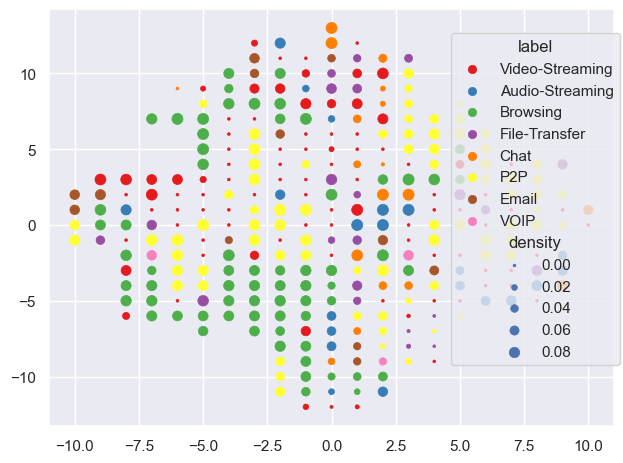

In [12]:
som.plot(color="label", palette="Set1", pointsize="density")


In [9]:
pipe_small.transform(X_test)[:,11].max()

2.4349407405541617

In [10]:
np.where(pipe_small.get_feature_names_out()=="Src Port_80")

(array([1], dtype=int64),)

In [11]:
X_test.shape

(35383, 79)